In [763]:
"""
Code written by Dautrevaux Cyprien,

02/11/2024
"""

# Libraries importation
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [764]:
def Sigmodal(x1, alpha=-0.56, r0=0.5):
    '''
    The sigmoid function is used here to transpose the membrane potential of every neurons into a instant firing rate. 

        Parameters
    -----------
        x1	: variable of the function
        alpha   : parameter influencing the stepness of the sigmoid curve (the smaller the stepper)
        r0  : Scaling factor 


        Returns
    -----------
        S = (2*r0/(1. + np.exp(alpha * x1)))
        S   : position of the x1 variable on the sigmoïd curve
    '''
    S = (2 * r0 / (1. + np.exp(alpha * x1)))
    return S


def izhikevich_connected(cst, x_init, param, m, I):
    """
    Parameters
    -----------
        cst	: Recording parameters and number of neurons (nn).
        x_init 	: np.Array containing all the intial state of V and U parameters of every neurons. Usually U = 0.2 * V. 
        param	: np.Array shape 5 * number of neurons. This array contains the parameters a,b,c,d and the extrinsic input i for every neurons.
        m   : The effective connectivity matrix, must be shape nn * nn. 
        I   : Injected current to simulated neurons, should be shape (nn, duration of the simulation)

        Returns
    -----------
        V & U   : Returns 2 list, shape : nn * dur/dt. The first one containing the membrane potential of every neuron, this other containing the U parameter. 
    """
    # Recording parameters defintion :
    dt, dur, nn = cst
    nn = int(nn)

    # Neurons parameters defintion :
    a = param[0, :]
    b = param[1, :]
    c = param[2, :]
    d = param[3, :]

    # Neurons initials conditions :
    V = np.zeros((nn, int(dur/dt)))
    V[:, 0] = x_init[:, 0]

    U = np.zeros((nn, int(dur/dt)))
    U[:, 0] = x_init[:, 1]

    # Differential equations integration for every neurons :
    for i in tqdm.trange(int(dur/dt)-1):
        # Definiton of the strength of projection
        S = Sigmodal(V[:, i], r0=2)
        other_neuron_input = S @ m

        # Integration of every neuron potential
        V[:, i+1] = V[:, i] + dt * (0.04 * V[:, i]**2 + 5 * V[:, i] + 140 - U[:, i] + (I[:, i] + other_neuron_input) + np.random.normal(loc=0, scale=1, size=nn) * 2) 
        U[:, i+1] = U[:, i] + dt * (a * (b * V[:, i] - U[:, i]))

    # Other condition
        index = np.where(V[:, i] >= 30)[0]

        V[index, i+1] = c[index]
        U[index, i+1] = U[index, i] + d[index]
        V[index, i] = 30

    return V + np.random.random(V.shape[-1]), U  # Add an observable noise

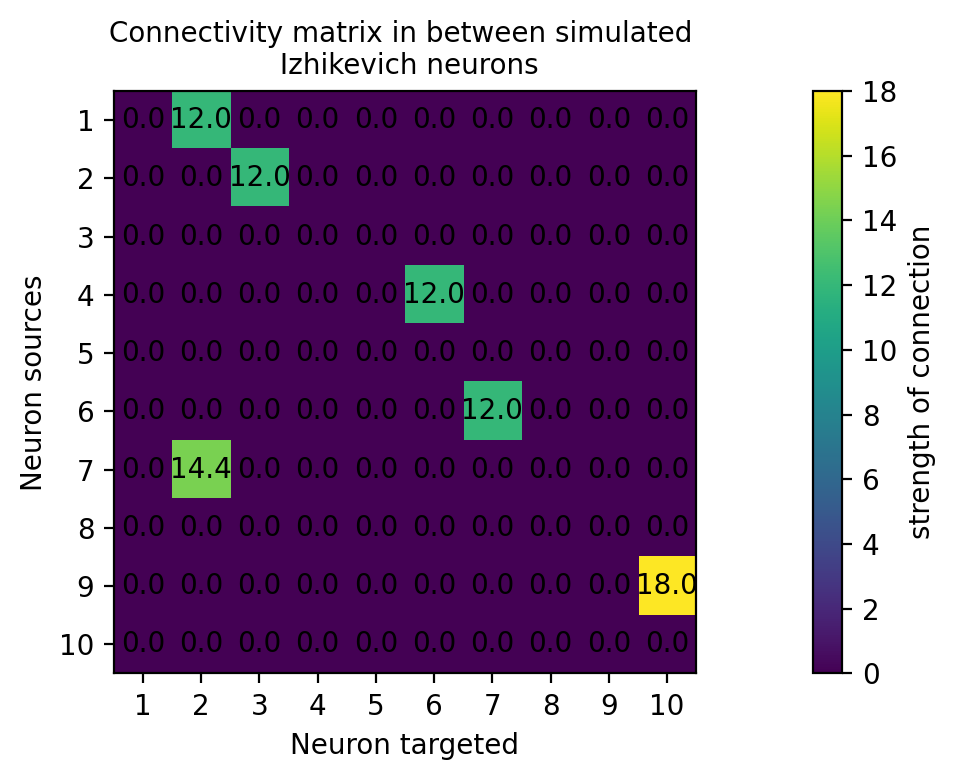

In [765]:
# -----------------------
dt = 0.1  # Time step / eq sampling freq
dur = 2_000  # Duration of the simuation
nn = 10  # nbr of neurons

# -----------------------
# -- Intial conditions --
# -----------------------

# x_init shape nbr_neuron, 2 for V & U
x_init = np.ones((nn, 2))
random_v0 = np.random.choice([-70, -65], size=nn)
x_init[:, 0] = random_v0 #  Random V0 between -70 & -65
x_init[:, 1] = random_v0 * 0.2 #  U = 0.2 * V0

cst = np.array([dt, dur, nn])


# Definiton of the parameters for every neurons
a = np.random.choice([0.01, 0.02], size=nn, p=[0.8, 0.2])
b = np.ones(nn) * 0.2
c = np.random.choice([-50, -65], size=nn, p=[0.8, 0.2])
d = np.random.choice([2.5, 8], size=nn, p=[0.5, 0.5])

param = np.vstack((a, b, c, d))

# -- Input current --
# Defintion of the Injected current in the neurons

I = np.zeros((nn, int(dur/dt)))
# Only the first neuron receive a driving input
# The input start after 40 ms and ends at 390ms
start_input = int(50/dt)
end_input = int(1900/dt)

I[0, start_input:end_input] = 5
I[3, start_input:end_input] = 5

I[8, start_input:end_input] = 5

# -----------------------
# Ajacency matrix (or in other words Connectivity matrix)
# Every values in the matrix being the strengh of connection between pairs of neurons

m = np.zeros((nn, nn))
m[0, 1] = 1  # Projection from neuron 1 to 2
m[1, 2] = 1  # Projection from neuron 2 to 3

m[3, 5] = 1  # Projection from neuron 4 to 6
m[5, 6] = 1  # Projection from neuron 6 to 7
m[6, 1] = 1.2  # Projection from neuron 7 to 2

m[8, 9] = 1.5  # Projection from neuron 7 to 2

m = m * 12

# Plotting the connectivity matrix
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=200)
mat = ax.imshow(m)
for (j, k), label in np.ndenumerate(m):
    ax.text(k, j, round(label, 2), ha='center', va='center')
ax.set(xticks=range(nn), yticks=range(nn), xticklabels=range(1, nn+1, 1),
       yticklabels=range(1, nn+1, 1), xlabel="Neuron targeted", ylabel="Neuron sources")
fig.colorbar(mappable=mat, ax=ax, shrink=1, label="strength of connection")
ax.set_title(
    "Connectivity matrix in between simulated \n Izhikevich neurons", fontsize=10)
plt.tight_layout()

100%|██████████| 19999/19999 [00:00<00:00, 62661.97it/s]


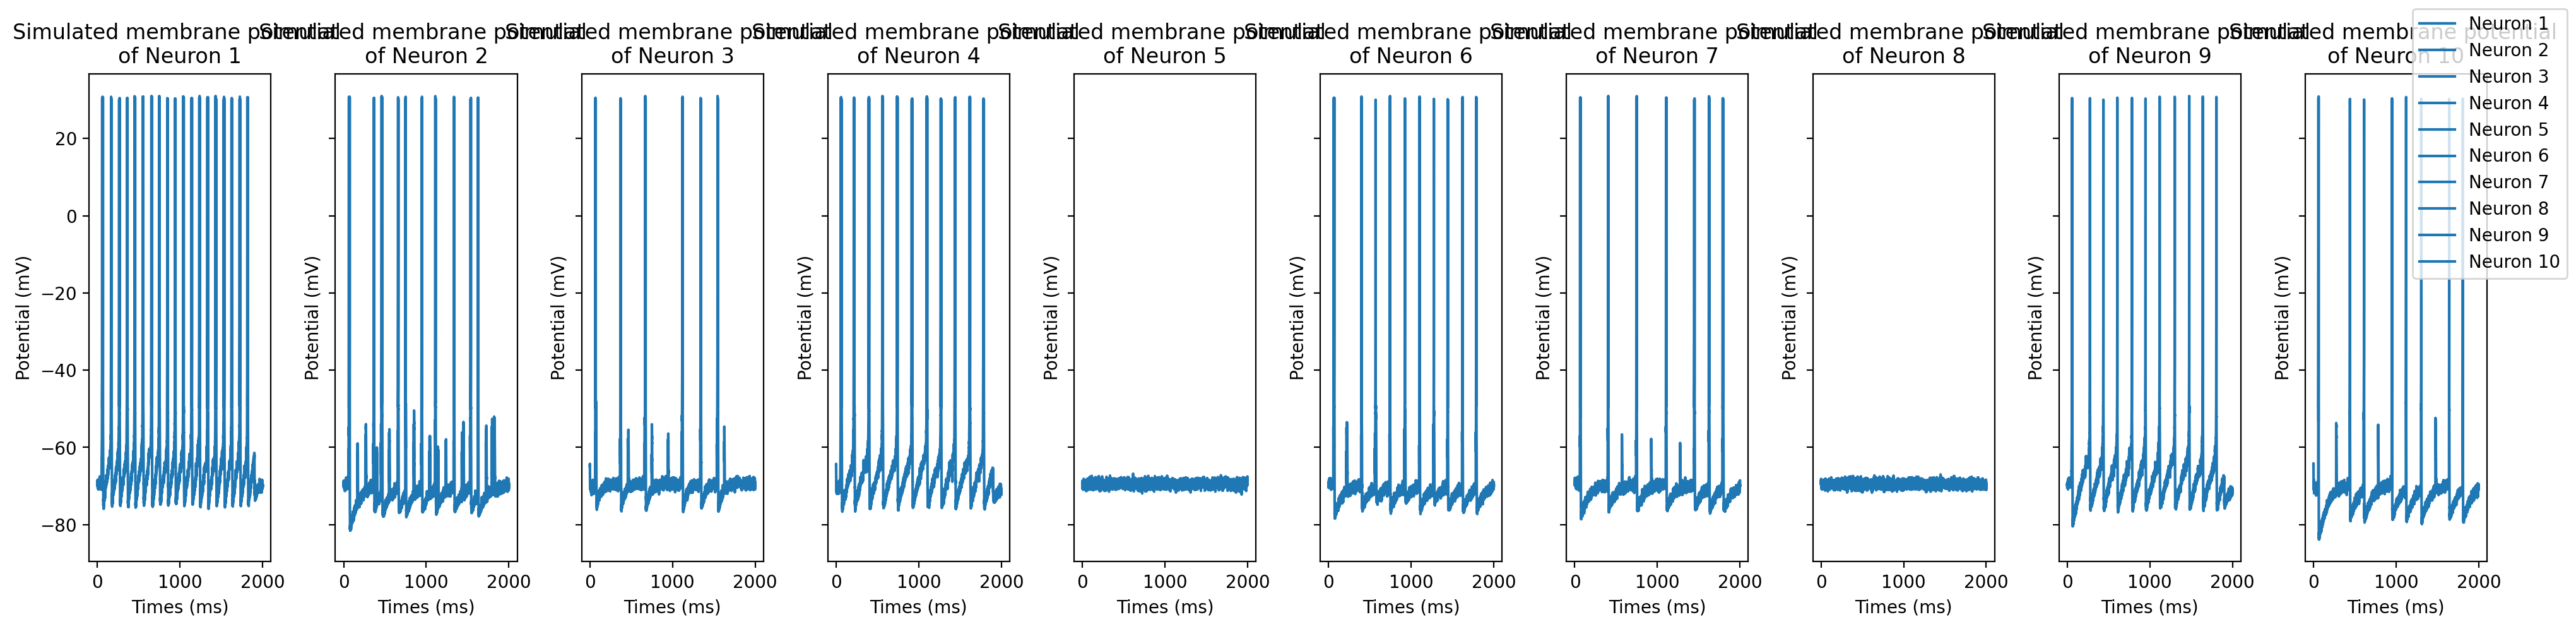

In [766]:

# Simulation
V, U = izhikevich_connected(cst=cst, x_init=x_init, param=param, m=m, I=I)

# Time serizs for the plot
time = np.arange(0, dur, dt)

# Plotting the neurons
fig, ax = plt.subplots(1, nn, figsize=(20, 5), dpi=200, sharey=True)

for i in range(nn):
    ax[i].plot(time, V[i, :], label=f"Neuron {i+1}")  # , color=colors[i])
    ax[i].set_title(f"Simulated membrane potential \nof Neuron {i+1}")
    ax[i].set(xlabel="Times (ms)", ylabel="Potential (mV)")
fig.legend()
plt.tight_layout()

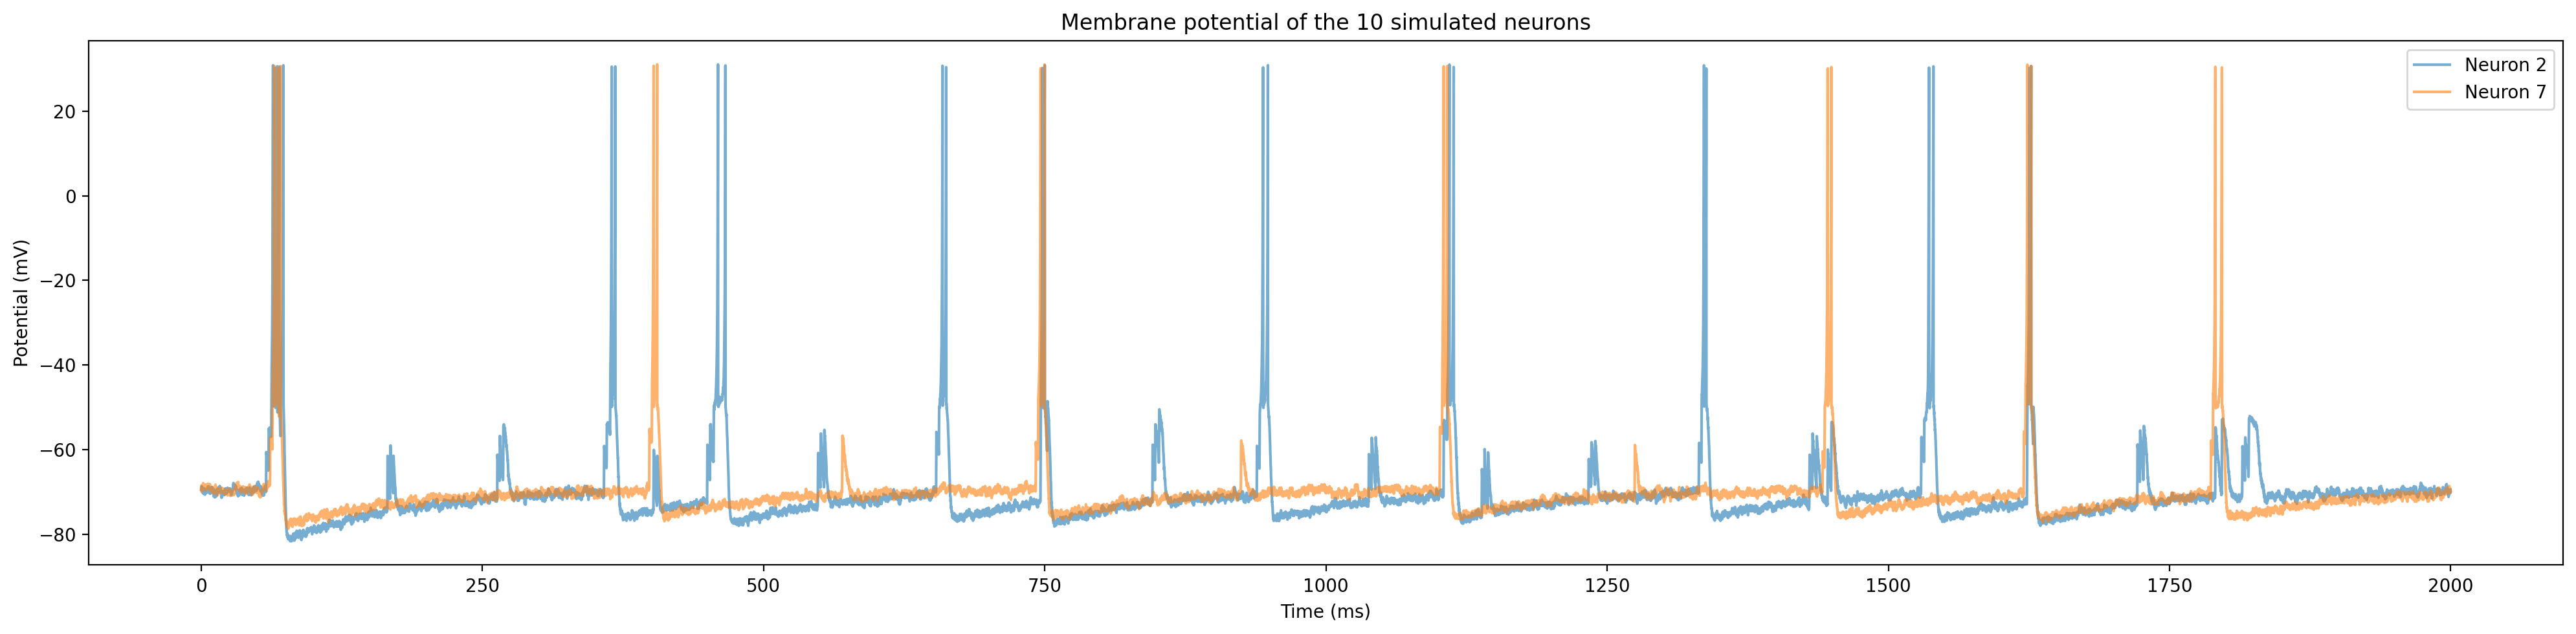

In [767]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=200)
for i in [1, 6]:
    ax.plot(time, V[i, :],
            label=f"Neuron {i+1}", alpha=0.6)  # , color=colors[i])
plt.legend()
ax.set_title(f"Membrane potential of the {nn} simulated neurons")
ax.set(xlabel="Time (ms)", ylabel="Potential (mV)")
plt.tight_layout()

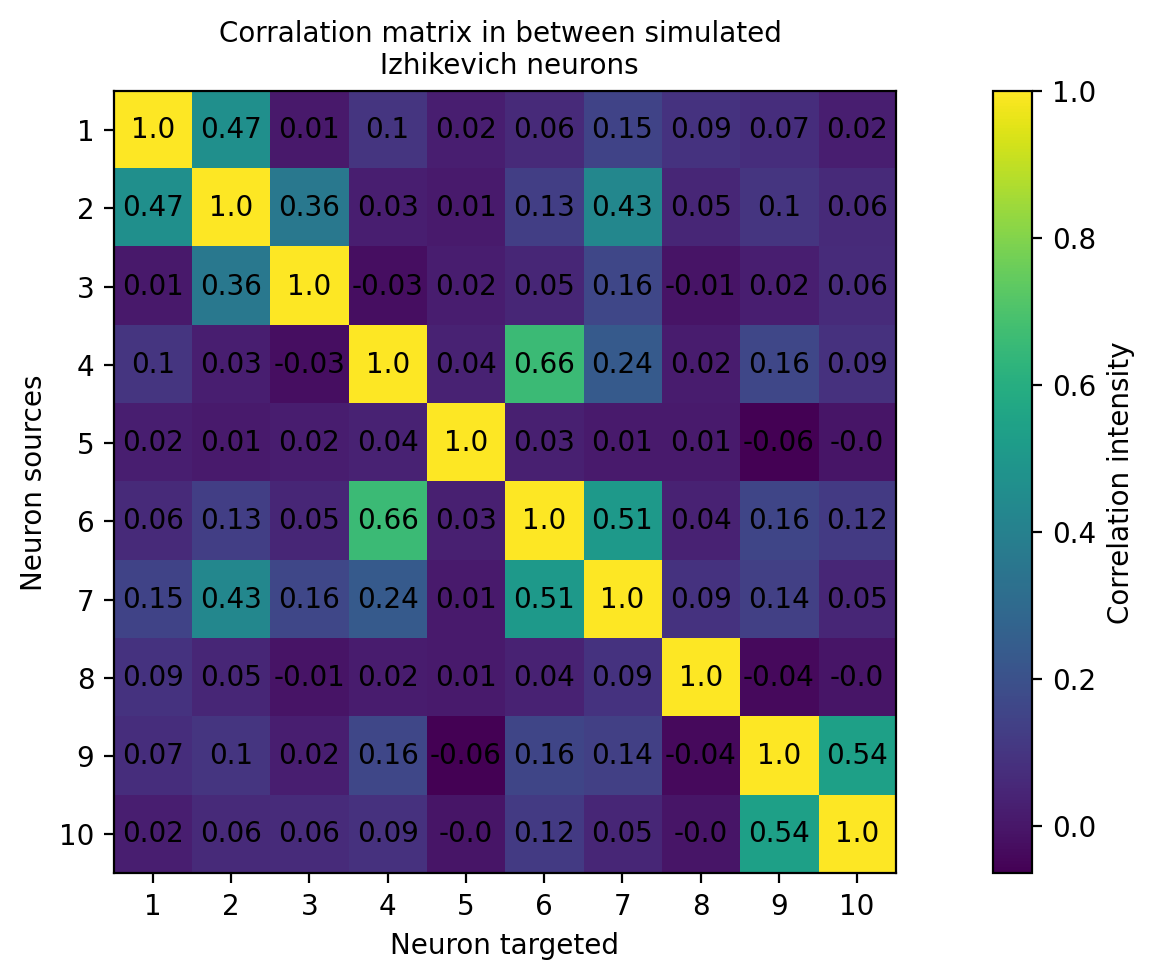

In [768]:
# Import Scipy to apply a very simple filter on the signals
import scipy as sc

# Extracting the correlation in between time series (Neurons)
corr = np.corrcoef(sc.signal.savgol_filter(V, 40, 0))

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
mat = ax.imshow(corr)
for (j, k), label in np.ndenumerate(corr):
    ax.text(k, j, round(label, 2), ha='center', va='center')

ax.set(xticks=range(nn), yticks=range(nn), xticklabels=range(1, nn+1, 1),
       yticklabels=range(1, nn+1, 1), xlabel="Neuron targeted", ylabel="Neuron sources")
fig.colorbar(mappable=mat, ax=ax, shrink=1, label="Correlation intensity")

ax.set_title(
    "Corralation matrix in between simulated \n Izhikevich neurons", fontsize=10)
plt.tight_layout()

In [3]:
# # Saving the simulations
# import os 
# cwd = os.getcwd()

# np.savez(os.path.join(cwd, "Izhi_neurons"), potential = V)
# np.savez(os.path.join(cwd, "True_conn_matrix"), matrix = m)
